<a href="https://colab.research.google.com/github/Kaustuv1234/MTech_image_segmentation/blob/master/output_picie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install torchvision==0.4.0
!pip install scikit-learn==0.22.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.8 MB 4.4 MB/s 
     |████████████████████████████████| 748.9 MB 622 bytes/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.2.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.2.0 which is incompatible.
fastai 2.6.3 requires torch<1.12,>=1.7.0, but you have torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 4.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.22.1 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.22.1 which is incompatible.
fastai 2.6.3 requires torch<1.12,>=1.7.0, but you have torch 1.2.0 which is incompatible.
fastai 2.6.3 requires torchvision>=0.8.2, but you have torchvision 0.4.0 which is incompatible.


In [1]:
!gdown 1_mqJKc7DInyO7UHwpOAD5Hzmt1Jgc4Jl

Downloading...
From: https://drive.google.com/uc?id=1_mqJKc7DInyO7UHwpOAD5Hzmt1Jgc4Jl
To: /content/picie.pkl
100% 136M/136M [00:00<00:00, 205MB/s]


In [5]:
!git clone https://github.com/janghyuncho/PiCIE.git

fatal: destination path 'PiCIE' already exists and is not an empty directory.


In [1]:
!mv PiCIE/* ./

mv: cannot stat 'PiCIE/*': No such file or directory


In [3]:
import os 
import torch  
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import numpy as np
import matplotlib.pyplot as plt 

from torchvision import transforms
from modules import fpn 
from PIL import Image 

# 0. Prepare helper functions.

In [4]:
class Args:
    def __init__(self):
        pass
    
def collate_eval(batch):
    indice = [b[0] for b in batch]
    image = torch.stack([b[1] for b in batch])
    if batch[0][-1] is not None:
        label = torch.stack([b[2] for b in batch])

        return indice, image, label
    else:
        return indice, image
    
def get_score_histogram(label_trues, label_preds, n_class):
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    
    return hist

def compute_dist(featmap, metric_function, euclidean_train=True):
    centroids = metric_function.module.weight.data
    if euclidean_train:
        return - (1 - 2*metric_function(featmap)\
                    + (centroids*centroids).sum(dim=1).unsqueeze(0)) # negative l2 squared 
    else:
        return metric_function(featmap)

preprocess = transforms.Compose([transforms.ToTensor(), 
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                      std=[0.229, 0.224, 0.225])])


In [5]:
args = Args()

# Model
args.pretrain = True 
args.ssl = False 
args.ssl_dir = False 
args.arch = 'resnet18'

# Classifier
args.in_dim = 128
args.K = 27

# Dataloader
args.data_root = ''

# 1. Load PiCIE.

**NOTE**: Place the COCO version of PiCIE weight at "picie.pkl" 

In [6]:
picie_load = torch.load('picie.pkl', 'cpu')

model = fpn.PanopticFPN(args)
model = nn.DataParallel(model)
model.load_state_dict(picie_load['state_dict'])

classifier = nn.Conv2d(args.in_dim, args.K, kernel_size=1, stride=1, padding=0, bias=True)
classifier = nn.DataParallel(classifier)
classifier.load_state_dict(picie_load['classifier1_state_dict'])

# Important ! 
model.eval()
classifier.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 38.4MB/s]


DataParallel(
  (module): Conv2d(128, 27, kernel_size=(1, 1), stride=(1, 1))
)

# 2. Cluster the data with pre-trained PiCIE. 

In [7]:
# Run below.
# python prepare_histogram.py --data_root datasets --save_root results --stuff --thing --eval_path "picie.pkl"

# 3. For each cluster, assign a class label with the majority vote. 

In [8]:
histogram_train = torch.load('picie_histogram_coco.pkl')

histogram_train = histogram_train.astype(int)
histogram_train = torch.tensor(histogram_train).topk(1, dim=0)[1].flatten()

map_fn_train = lambda x: histogram_train[x]
mapper_train = np.vectorize(map_fn_train)

# 4. Visualize the predictions. 
Here is an image from the internet. We will visualize how well our model recognizes this image. 

In [9]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [12]:
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset
!unzip -q /content/deepglobe-road-extraction-dataset.zip

deepglobe-road-extraction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace class_dict.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [13]:
import os
import random
imgs = os.listdir('valid')
imgs = random.sample(imgs, k=2)

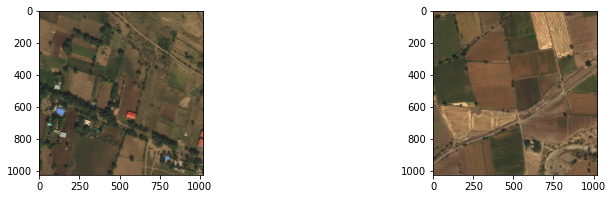

	 Animal						Building


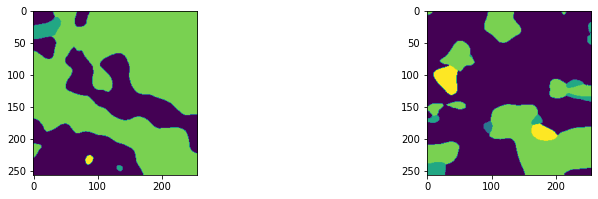

In [15]:
fig = plt.figure(figsize=(10, 10))

img_raw1 = Image.open(f'valid/{imgs[0]}').convert('RGB')
img_raw2 = Image.open(f'valid/{imgs[1]}').convert('RGB')

fig.add_subplot(1, 3, 1)
plt.imshow(img_raw1)

fig.add_subplot(1, 3, 3)
plt.imshow(img_raw2)
plt.show()
print('\t Animal\t\t\t\t\t\tBuilding')
img1 = preprocess(img_raw1)[None, :]
out1 = model(img1)
out1 = F.normalize(out1, dim=1, p=2)
prb1 = compute_dist(out1, classifier)
lbl1 = prb1.topk(1, dim=1)[1]
lbl1 = lbl1.squeeze(0).squeeze(0)

img2 = preprocess(img_raw2)[None, :]
out2 = model(img2)
out2 = F.normalize(out2, dim=1, p=2)
prb2 = compute_dist(out2, classifier)
lbl2 = prb2.topk(1, dim=1)[1]
lbl2 = lbl2.squeeze(0).squeeze(0)
from matplotlib import colors

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 3, 1)
plt.imshow(mapper_train(lbl1))

fig.add_subplot(1, 3, 3)
plt.imshow(mapper_train(lbl2))
plt.show()

As seen above, our model is able to group semantically consistent pixeles.

# 5. Visualize the nearest neighbors. 

We further investigate by looking at the nearest neighbors from the validation set of COCO dataset. First, pick a query position on each image. They are *Animal* and *Building* classes, respectively.

In [ ]:
from matplotlib.patches import Rectangle 

fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(img_raw1)
ax = plt.gca()

# w, h
pos1  = (150, 50)
rect1 = Rectangle(pos1, 5, 5, linewidth=5, edgecolor='r', facecolor='none')
ax.add_patch(rect1)

fig.add_subplot(1, 3, 3)
plt.imshow(img_raw2)
ax = plt.gca()

# w, h
pos2  = (80, 120)
rect2 = Rectangle(pos2, 5, 5, linewidth=5, edgecolor='r', facecolor='none')
ax.add_patch(rect2)
plt.show()
print('\t Animal\t\t\t\t\t\tBuilding')

The feature maps are down-sized as below.

In [ ]:
print('Image 1 shape       : ', img_raw1.size[::-1])
print('Feature map 1 shape : ', lbl1.numpy().shape)
print('Image 2 shape       : ', img_raw2.size[::-1])
print('Feature map 2 shape : ', lbl2.numpy().shape)

We extract the pixel-level feature for each query and save. 

In [ ]:
# h, w
fpos1 = (pos1[1]*55//217, pos1[0]*73//289)
fpos2 = (pos2[1]*55//217, pos2[0]*36//144)

query1 = out1[:, :, fpos1[0], fpos1[1]]
query2 = out2[:, :, fpos2[0], fpos2[1]]
querys = torch.cat([query1, query2])

print('Image 1 query position : ', fpos1)
print('Image 2 query position : ', fpos2)

In [ ]:
# Save queries.
# np.save('querys.npy', querys.detach().numpy())

Now, we will look for the 5-nearest neighbors for each of these queries. The command below will retrieve the nearest neighbors of each query from the validation set of COCO images.

In [ ]:
# Run below.
# python retrieval.py --data_root datasets/coco --save_root . --stuff --thing --val_type val --K_test 5 --eval_path "picie.pkl"

In [ ]:
imglist, loclist = torch.load('picie_retrieval_result_coco.pkl')

In [ ]:
def show_neighbors(img_raw, q_loc, imglist_c, loclist_c):
    fig = plt.figure(figsize=(12, 12))
    fig.add_subplot(1, 3, 2)
    plt.imshow(img_raw)
    ax = plt.gca()

    rect = Rectangle(q_loc, 5, 5, linewidth=8, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

    fig = plt.figure(figsize=(20, 100))
    for i, (img, loc) in enumerate(zip(imglist_c, loclist_c)):
        fig.add_subplot(1, 5, i+1)
        plt.imshow(img)
        ax = plt.gca()

        _, h, w = loc
        rect = Rectangle((4*w, 4*h), 5, 5, linewidth=8, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

print('\n\n\n')
print('\t\t\t\t\t\t\tAnimal')
show_neighbors(img_raw1, pos1, imglist[0], loclist[0])
print('\n\n\n')
print('\t\t\t\t\t\t\tBuilding')
show_neighbors(img_raw2, pos2, imglist[1], loclist[1])

Both *Animal* and *Building* have semantically consistent nearest neighbors. 